In [1]:
import numpy as np
from scipy.integrate import quad
from scipy.special import exp1, gamma
import scipy.constants as const
import matplotlib.pyplot as plt

def pertCoeffMatrix(param):
    
    alpha = param['alpha'] / (10 * np.log10(np.exp(1)))
    
    beta2 = -param['D'] * (param['lambda'])**2 / (2 * np.pi * const.c / 1e3)
    
    Leff = (1 - np.exp(-alpha * param['lspan'])) / alpha
    
    nSpans = param['length'] // param['lspan']

    M, N = np.meshgrid(
        np.arange(-param['matrixOrder'], param['matrixOrder'] + 1),
        np.arange(param['matrixOrder'], -param['matrixOrder'] - 1, -1)
    )

    constantIntegral = param['pulseWidth']**4 / (3 * beta2**2)
    fun1 = lambda z, c: 1 / np.sqrt(c + z**2)

    C_ispm, _ = quad(lambda z: fun1(z, constantIntegral), 0, param['length'])

    if param['powerWeighted']:
        Acoeff = M * N * param['symbolPeriod']**2 / beta2
        sum1 = np.zeros_like(M)
        sum2 = np.zeros_like(M)
        Norder = param['powerWeightN']

        for indSpan in range(1, nSpans + 1):
            Bcoeff = -Norder / (alpha * Acoeff) + ((indSpan - 1) * param['lspan']) / Acoeff
            for kk in range(1, Norder + 1):
                if indSpan != 1:
                    GammaPrevious = gamma(1 - kk) * exp1(1j * (1 / Bcoeff - Acoeff / ((indSpan - 1) * param['lspan'])))
                else:
                    GammaPrevious = np.zeros_like(M)
                GammaNext = gamma(1 - kk) * exp1(1j * (1 / Bcoeff - Acoeff / (indSpan * param['lspan'])))

                if kk == 1:
                    sum2 = (-1)**(kk + Norder) * comb(Norder - 1, kk - 1) * (1j / Bcoeff)**kk * (GammaPrevious - GammaNext)
                else:
                    sum2 += (-1)**(kk + Norder) * comb(Norder - 1, kk - 1) * (1j / Bcoeff)**kk * (GammaPrevious - GammaNext)

            if indSpan == 1:
                sum1 = (np.exp(1j / Bcoeff) / Bcoeff**(Norder - 1)) * sum2
            else:
                sum1 += (np.exp(1j / Bcoeff) / Bcoeff**(Norder - 1)) * sum2

        C_ifwm = (Norder / alpha)**Norder * (Acoeff**(-Norder)) * sum1
    else:
        C_ifwm = exp1(-1j * M * N * param['symbolPeriod']**2 / (beta2 * param['length']))

    C_ixpm = 0.5 * exp1((N - M)**2 * param['symbolPeriod']**2 * param['pulseWidth']**2 / (3 * np.abs(beta2)**2 * param['length']**2))
        
    if param['powerWeighted']:
        C_ifwm_mask = np.isnan(np.abs(C_ifwm)).astype(float)
        C_ifwm[np.isnan(np.abs(C_ifwm))] = 0
    else:
        C_ifwm_mask = np.isinf(np.abs(C_ifwm)).astype(float)
        C_ifwm[np.abs(C_ifwm) == np.inf] = 0

    C_ixpm[np.abs(C_ixpm) == np.inf] = 0
    C_ixpm = C_ifwm_mask * C_ixpm

    if param['powerWeighted']:
        C_ifwm = -(8 / 9) * param['gamma'] * param['pulseWidth']**2 / (np.sqrt(3) * beta2) * C_ifwm
        C_ixpm = 1j * (8 / 9) * param['gamma'] * param['pulseWidth']**2 / (np.sqrt(3) * np.abs(beta2)) * C_ixpm * Leff / param['lspan']
        C_ispm = 1j * (8 / 9) * param['gamma'] * param['pulseWidth']**2 / (np.sqrt(3) * np.abs(beta2)) * C_ispm * Leff / param['lspan']
    else:
        C_ifwm = 1j * (8 / 9) * param['gamma'] * param['pulseWidth']**2 / (np.sqrt(3) * np.abs(beta2)) * C_ifwm * Leff / param['lspan']
        C_ixpm = 1j * (8 / 9) * param['gamma'] * param['pulseWidth']**2 / (np.sqrt(3) * np.abs(beta2)) * C_ixpm * Leff / param['lspan']
        C_ispm = 1j * (8 / 9) * param['gamma'] * param['pulseWidth']**2 / (np.sqrt(3) * np.abs(beta2)) * C_ispm * Leff / param['lspan']

    C = C_ifwm + C_ixpm
    C[param['matrixOrder'], param['matrixOrder']] = C_ispm

    return C, C_ifwm, C_ixpm, C_ispm


In [85]:
Rs = 32e9

# Define the input parameters
param = {
    'alpha': 0.2,
    'D': 17,
    'lambda': 1550.12e-12,    
    'lspan': 50,
    'length': 40*50,
    'matrixOrder': 100,
    'pulseWidth': 0.55*1/Rs,
    'symbolPeriod': 1/Rs,
    'powerWeighted': False,
    'powerWeightN': 2,
    'gamma': 1.3
}

# Call the function
C, C_ifwm, C_ixpm, C_ispm = pertCoeffMatrix(param);

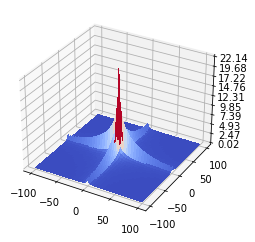

In [86]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import numpy as np

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# Make data.
M, N = np.meshgrid(
        np.arange(-param['matrixOrder'], param['matrixOrder'] + 1),
        np.arange(param['matrixOrder'], -param['matrixOrder'] - 1, -1)
    )

# Plot the surface.
surf = ax.plot_surface(M, N, np.abs(C), cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
ax.zaxis.set_major_formatter('{x:.02f}')

plt.show()

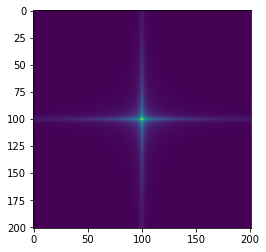

In [87]:
plt.imshow(np.abs(C));

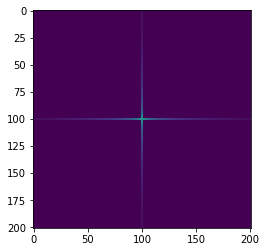

In [88]:
plt.imshow(np.abs(C_ixpm));

In [92]:
import numpy as np
from tqdm.notebook import tqdm
from numba import njit, prange, jit

#@njit
def additiveMultiplicativeModelNLINwaveform(x, y, C_ifwm, C_ixpm, C_ispm):
    L = (len(C_ifwm) - 1) // 2
    D = len(C_ifwm) - 1
    
    C = C_ifwm + C_ixpm
    C[D, D] = C_ispm
    C_mNonEqualZero = np.copy(np.abs(C))
    C_mNonEqualZero[:, L] = np.zeros(D+1, dtype='float')+1e-100
    
    indMask1 = (1.0 / C_mNonEqualZero.T)>1e50
    indMask2 = (1.0 / C_mNonEqualZero)>1e50
    C_ixpm_mask1 = C_ixpm * indMask1
    C_ixpm_mask2 = C_ixpm * indMask2
    x = pnorm(x)
    y = pnorm(y)
    
    dx = np.zeros(x.shape, dtype='complex')
    dy = np.zeros(y.shape, dtype='complex')
    
    phi_ixpm_x = np.zeros(x.shape, dtype = 'float')
    phi_ixpm_y = np.zeros(y.shape, dtype = 'float')
    
    symbX = np.concatenate((np.zeros(D), x, np.zeros(D)))
    symbY = np.concatenate((np.zeros(D), y, np.zeros(D)))
    
    ind = np.arange(0, 2*L+1)
    r = len(ind)
    M = ind.repeat(r).reshape((-1, r))
    
    NplusM = -((M.T - L) + (M - L)) + len(C) -1
    NplusM = np.flipud(NplusM)
    
    NplusM = np.rot90(NplusM, 2)
    
    X_NplusM = np.zeros(NplusM.shape, dtype='complex')
    Y_NplusM = np.zeros(NplusM.shape, dtype='complex')
    Xn = np.zeros(NplusM.shape, dtype='complex')
    Yn = np.zeros(NplusM.shape, dtype='complex')
    
    #for t in range(D, len(symbX)-D):
    for t in tqdm(range(D, len(symbX)-D)):
        x_2D = symbX[t-D:t+D+1]
        y_2D = symbY[t-D:t+D+1]
        
        centerwindow = (len(x_2D)-1) // 2
        
        for d in range(X_NplusM.shape[0]):
            X_NplusM[d,:] = x_2D[NplusM[d,:]]
            Y_NplusM[d,:] = y_2D[NplusM[d,:]]  
            Xn[d,:] = x_2D[centerwindow-L:centerwindow+L+1]
            Yn[d,:] = y_2D[centerwindow-L:centerwindow+L+1]                 

        Xm = Xn.T
        Ym = Yn.T       
        
        Xn = np.flipud(Xn)
        Yn = np.flipud(Yn)
        
        Yn_conj_Ynm_Xm = Yn * np.conj(Y_NplusM) * Xm
        Xn_conj_Xnm_Ym = Xn * np.conj(X_NplusM) * Ym
        
        DX = (Xn * np.conj(X_NplusM) * Xm + Yn_conj_Ynm_Xm)
        DY = (Yn * np.conj(Y_NplusM) * Ym + Xn_conj_Xnm_Ym)
        
        Abs2Xm = np.abs(Xm)**2
        Abs2Ym = np.abs(Ym)**2
        
        phi_ixpm_x[t-D] = np.imag(np.sum( (2 * Abs2Xm + Abs2Ym) * C_ixpm_mask1 
                                  + (np.abs(Xm[L, L])**2 + np.abs(Ym[L, L])**2) * C_ispm))
        
        phi_ixpm_y[t-D] = np.imag(np.sum( (2 * Abs2Ym + Abs2Xm) * C_ixpm_mask1 
                                  + (np.abs(Ym[L, L])**2 + np.abs(Xm[L, L])**2) * C_ispm))
        
        dx[t-D] = np.sum(DX * C_ifwm + Yn_conj_Ynm_Xm * C_ixpm_mask2)
        dy[t-D] = np.sum(DY * C_ifwm + Xn_conj_Xnm_Ym * C_ixpm_mask2)

    return dx, dy, phi_ixpm_x, phi_ixpm_y

In [90]:
np.array([[1,2,3,4]]).repeat(4).reshape((-1, 4)).T

array([[1, 2, 3, 4],
       [1, 2, 3, 4],
       [1, 2, 3, 4],
       [1, 2, 3, 4]])

In [105]:
import numpy as np
from numba import cuda, float64, complex128

@cuda.jit
def additiveMultiplicativeModelNLINwaveform(x, y, C_ifwm, C_ixpm, C_ispm, dx, dy, phi_ixpm_x, phi_ixpm_y, NplusM):
    L = (len(C_ifwm) - 1) // 2
    D = len(C_ifwm) - 1

    C = C_ifwm + C_ixpm
    C[D, D] = C_ispm
    C_mNonEqualZero = cuda.local.array((D + 1, D + 1), dtype=float64)
    for i in range(D + 1):
        for j in range(D + 1):
            C_mNonEqualZero[i, j] = abs(C[i, j])
    C_mNonEqualZero[:, L] = 1e-100

    tx = cuda.threadIdx.x
    bx = cuda.blockIdx.x
    bw = cuda.blockDim.x
    ind = tx + bx * bw

    if ind < len(x):
        indMask1 = 1.0 / C_mNonEqualZero.T > 1e50
        indMask2 = 1.0 / C_mNonEqualZero > 1e50
        C_ixpm_mask1 = C_ixpm * indMask1
        C_ixpm_mask2 = C_ixpm * indMask2
        x_val = pnorm(x[ind])
        y_val = pnorm(y[ind])

        dx_val = 0.0
        dy_val = 0.0
        phi_ixpm_x_val = 0.0
        phi_ixpm_y_val = 0.0

        symbX = cuda.local.array(D * 2 + len(x), dtype=complex128)
        symbY = cuda.local.array(D * 2 + len(y), dtype=complex128)
        symbX[D: D + len(x)] = x_val
        symbY[D: D + len(y)] = y_val

        X_NplusM = cuda.local.array((D + 1, D + 1), dtype=complex128)
        Y_NplusM = cuda.local.array((D + 1, D + 1), dtype=complex128)

        for t in range(D, len(x_val) - D):
            x_2D = cuda.local.array(D * 2 + 1, dtype=complex128)
            y_2D = cuda.local.array(D * 2 + 1, dtype=complex128)
            for i in range(D * 2 + 1):
                x_2D[i] = symbX[t - D + i]
                y_2D[i] = symbY[t - D + i]

            for i in range(D + 1):
                for j in range(D + 1):
                    X_NplusM[i, j] = x_2D[NplusM[i, j]]
                    Y_NplusM[i, j] = y_2D[NplusM[i, j]]

            centerwindow = (len(x_2D) - 1) // 2
            Xn = cuda.local.array((2 * L + 1, 2 * L + 1), dtype=complex128)
            Yn = cuda.local.array((2 * L + 1, 2 * L + 1), dtype=complex128)
            Xm = cuda.local.array((2 * L + 1, 2 * L + 1), dtype=complex128)
            Ym = cuda.local.array((2 * L + 1, 2 * L + 1), dtype=complex128)

            for i in range(2 * L + 1):
                Xn[i] = x_2D[centerwindow - L + i]
                Yn[i] = y_2D[centerwindow - L + i]
                Xm[i] = Xn.T[i]
                Ym[i] = Yn.T[i]

            DX = cuda.local.array((2 * L + 1, 2 * L + 1), dtype=complex128)
            DY = cuda.local.array((2 * L + 1, 2 * L + 1), dtype=complex128)
            for i in range(2 * L + 1):
                for j in range(2 * L + 1):
                    DX[i, j] = Xn[i, j] * X_NplusM[i, j].conjugate() * Xm[i, j] + Yn[i, j] * Y_NplusM[i, j].conjugate() * Xm[i, j]
                    DY[i, j] = Yn[i, j] * Y_NplusM[i, j].conjugate() * Ym[i, j] + Xn[i, j] * X_NplusM[i, j].conjugate() * Ym[i, j]

            phi_ixpm_x_val = phi_ixpm_x_val + np.imag(np.sum((2 * np.abs(Xm) ** 2 + np.abs(Ym) ** 2) * C_ixpm_mask1
                                             + (np.abs(Xm[L, L]) ** 2 + np.abs(Ym[L, L]) ** 2) * C_ispm))
            phi_ixpm_y_val = phi_ixpm_y_val + np.imag(np.sum((2 * np.abs(Ym) ** 2 + np.abs(Xm) ** 2) * C_ixpm_mask1
                                             + (np.abs(Ym[L, L]) ** 2 + np.abs(Xm[L, L]) ** 2) * C_ispm))

            dx_val = dx_val + np.sum(DX * C_ifwm + (Yn * Y_NplusM * Xm) * C_ixpm_mask2)
            dy_val = dy_val + np.sum(DY * C_ifwm + (Xn * X_NplusM * Ym) * C_ixpm_mask2)

        dx[ind] = dx_val
        dy[ind] = dy_val
        phi_ixpm_x[ind] = phi_ixpm_x_val
        phi_ixpm_y[ind] = phi_ixpm_y_val

        
def additiveMultiplicativeModelNLINwaveform_gpu(x, y, C_ifwm, C_ixpm, C_ispm):
    L = (len(C_ifwm) - 1) // 2
    D = len(C_ifwm) - 1

    C = C_ifwm + C_ixpm
    C[D, D] = C_ispm
    C_mNonEqualZero = np.abs(C).copy()
    C_mNonEqualZero[:, L] = np.zeros(D + 1, dtype='float') + 1e-100

    indMask1 = (1.0 / C_mNonEqualZero.T) > 1e50
    indMask2 = (1.0 / C_mNonEqualZero) > 1e50
    C_ixpm_mask1 = C_ixpm * indMask1
    C_ixpm_mask2 = C_ixpm * indMask2
    x = pnorm(x)
    y = pnorm(y)

    dx = np.zeros(x.shape, dtype=np.complex128)
    dy = np.zeros(y.shape, dtype=np.complex128)
    phi_ixpm_x = np.zeros(x.shape, dtype=np.float64)
    phi_ixpm_y = np.zeros(y.shape, dtype=np.float64)
    symbX = np.concatenate((np.zeros(D), x, np.zeros(D)))
    symbY = np.concatenate((np.zeros(D), y, np.zeros(D)))

    ind = np.arange(0, 2 * L + 1)
    r = len(ind)
    M = ind.repeat(r).reshape((-1, r))

    NplusM = -((M.T - L) + (M - L)) + len(C) - 1
    NplusM = np.flipud(NplusM)
    NplusM = np.rot90(NplusM, 2)

    X_NplusM = np.zeros(NplusM.shape, dtype=np.complex128)
    Y_NplusM = np.zeros(NplusM.shape, dtype=np.complex128)

    block_size = 32
    num_blocks = (len(x) + block_size - 1) // block_size

    dx_gpu = cuda.to_device(np.ascontiguousarray(dx))
    dy_gpu = cuda.to_device(np.ascontiguousarray(dy))
    phi_ixpm_x_gpu = cuda.to_device(np.ascontiguousarray(phi_ixpm_x))
    phi_ixpm_y_gpu = cuda.to_device(np.ascontiguousarray(phi_ixpm_y))
    x_gpu = cuda.to_device(np.ascontiguousarray(symbX))
    y_gpu = cuda.to_device(np.ascontiguousarray(symbY))
    C_ifwm_gpu = cuda.to_device(np.ascontiguousarray(C_ifwm))
    C_ixpm_gpu = cuda.to_device(np.ascontiguousarray(C_ixpm))
    C_ispm_gpu = cuda.to_device(np.ascontiguousarray(C_ispm))
    NplusM_gpu = cuda.to_device(np.ascontiguousarray(NplusM))

    additiveMultiplicativeModelNLINwaveform[num_blocks, block_size](
        x_gpu, y_gpu, C_ifwm_gpu, C_ixpm_gpu, C_ispm_gpu, dx_gpu, dy_gpu, phi_ixpm_x_gpu, phi_ixpm_y_gpu, NplusM_gpu
    )

    dx = dx_gpu.copy_to_host()
    dy = dy_gpu.copy_to_host()
    phi_ixpm_x = phi_ixpm_x_gpu.copy_to_host()
    phi_ixpm_y = phi_ixpm_y_gpu.copy_to_host()

    return dx, dy, phi_ixpm_x, phi_ixpm_y


In [106]:
from optic.modulation import modulateGray, demodulateGray, GrayMapping
from optic.dsp import pnorm

# peak power
PeakPower = 5e-3

# select QAM order
M = 16

# parâmetros da simulação
SpS = 16            # Amostras por símbolo
Rs  = 32e9         # Taxa de símbolos
Ts  = 1/Rs          # Período de símbolo em segundos
Fa  = 1/(Ts/SpS)    # Frequência de amostragem do sinal (amostras/segundo)
Ta  = 1/Fa          # Período de amostragem

# get constellation    
constSymb = GrayMapping(M, 'qam')  # constellation
constSymb = pnorm(constSymb) 

# generate pseudo-random bit sequence
bitsX = np.random.randint(2, size = int(40000*np.log2(M)))
bitsY = np.random.randint(2, size = int(40000*np.log2(M)))

# generate modulated symbol sequence
symbX = modulateGray(bitsX, M, 'qam')    
symbY = modulateGray(bitsY, M, 'qam')  

symbX = pnorm(symbX) # power normalization
symbY = pnorm(symbY) # power normalization

dx, dy, phi_ixpm_x, phi_ixpm_y = additiveMultiplicativeModelNLINwaveform_gpu(symbX, symbY, C_ifwm, C_ixpm, C_ispm)

dx = PeakPower**(3/2)*dx
dy = PeakPower**(3/2)*dy

phi_ixpm_x = PeakPower*phi_ixpm_x
phi_ixpm_y = PeakPower*phi_ixpm_y

TypingError: Failed in cuda mode pipeline (step: nopython frontend)
[1m[1mNo implementation of function Function(<built-in function add>) found for signature:
 
 >>> add(array(complex128, 2d, C), array(complex128, 2d, C))
 
There are 12 candidate implementations:
[1m      - Of which 2 did not match due to:
      Operator Overload in function 'add': File: unknown: Line unknown.
        With argument(s): '(array(complex128, 2d, C), array(complex128, 2d, C))':[0m
[1m       No match for registered cases:
        * (int64, int64) -> int64
        * (int64, uint64) -> int64
        * (uint64, int64) -> int64
        * (uint64, uint64) -> uint64
        * (float32, float32) -> float32
        * (float64, float64) -> float64
        * (complex64, complex64) -> complex64
        * (complex128, complex128) -> complex128[0m
[1m      - Of which 10 did not match due to:
      Overload of function 'add': File: <numerous>: Line N/A.
        With argument(s): '(array(complex128, 2d, C), array(complex128, 2d, C))':[0m
[1m       No match.[0m
[0m
[0m[1mDuring: typing of intrinsic-call at C:\Users\edson.DESKTOP-54IJM4F\AppData\Local\Temp\ipykernel_6596\224756886.py (9)[0m
[1m
File "..\..\..\..\AppData\Local\Temp\ipykernel_6596\224756886.py", line 9:[0m
[1m<source missing, REPL/exec in use?>[0m


In [ ]:
nlinX = symbX * (np.exp(1j*phi_ixpm_x)-1) + dx * np.exp(1j*phi_ixpm_x)
nlinY = symbY * (np.exp(1j*phi_ixpm_y)-1) + dy * np.exp(1j*phi_ixpm_y)

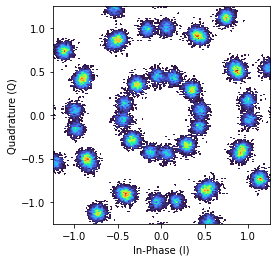

In [68]:
from optic.plot import pconst

pconst(symbX + nlinX);